## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 3 - Applying attenuation corrections

#### Overview
This notebook introduces a methods for correcting weather radar data for attenuation.

The notebook will cover:

1. Attenuation correction using only reflectivity
2. Differential phase shift measurements - filtering and calculating specific differential phase
3. Dual-polarisation attenuation correction


We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import wradlib
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file known to contain attenuating precipitation, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the clutter.

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200723/ncas-mobile-x-band-radar-1_sandwith_20200723-094532_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

#### Single polarisation attenuation correction using Hitschfeld and Bordan

For this practical we'll apply a gatefilter as shown in the previous practical notebooks, this will allow us to focus on the meteorological echoes in this case. We'll now plot up a multipanel PPI plot of 2 of the variables in the file (see practical 3 for more details on creating multi-panel plots). In addition to reflectivity (dBuZ) we'll also plot differential reflectivity (ZDR) to visually assess the likelihood of attenuation/differential attenuation.

In [3]:
radar.fields['uPhiDPu']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['uPhiDPu']['data']>180,
                                                                  radar.fields['uPhiDPu']['data']-360,
                                                                  radar.fields['uPhiDPu']['data']),
                                                    mask=radar.fields['uPhiDPu']['data'].mask)

gatefilter = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter.exclude_below('SQI',0.4)
gatefilter = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter)

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


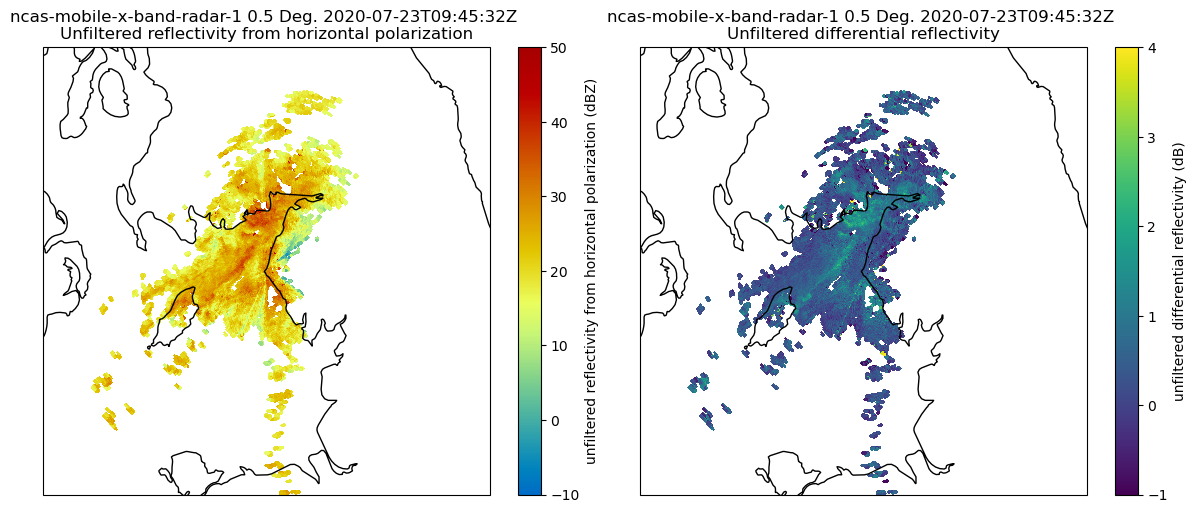

In [4]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=50,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("ZDRu", 0, 
                     vmin=-1, vmax=4,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax2)

ax2.coastlines(resolution='10m')

plt.tight_layout()

In this example the attenuation is not strikingly obvious, either in the horizontal reflectivity field or the differential reflectivity field. However the region of echoes in excess of 30dBZ to the north of the radar is extensive enough to cause moderate attenuation at X-band frequencies (remember from the lecture that attenuation is frequency dependent, where S-band frequencies have lower attenuation due to the increased wavelength). Starting with the single polarisation approach of Hitschfeld and Bordan (H-B) (1954) we can quantify the total attenuation in this case and apply a simple correction.

Wradlib contains an inbuilt function for applying the iterative H-B technique, [```wradlib.atten.correct_attenuation_hb```](https://docs.wradlib.org/en/latest/generated/wradlib.atten.correct_attenuation_hb.html#wradlib.atten.correct_attenuation_hb). We'll use that here, taking attenuation coefficients from the work of Diederich et al. 2014. These coefficients are frequency dependant (and also vary to a lesser degree as a function of temperature and DSD).


In [5]:
# We'll use the gatefilter to generate a filtered reflectivity field.
# Infilling a nominally small value where the gatefilter excludes data will allow the function to run
# without adding attenuation.
filtered_reflectivity = np.where(gatefilter.gate_included,
                                              radar.fields['dBuZ']['data'],
                                              -9e33)

attenuation_hb = wradlib.atten.correct_attenuation_hb(filtered_reflectivity, 
                                     coefficients={'a':1.62e-4, # 1.62e-4, 1.15e-4 (Values from Diederich et al 2014)
                                                   'b':0.74, # 0.74, 0.78
                                                   'gate_length':0.15})

## We'll add this data to the radar object as a new field. This will allow us to use the plotting functions to 
## visualise the results

radar.add_field('attenuation_HB', {'data': np.ma.masked_where(gatefilter.gate_excluded,
                                                           attenuation_hb),
                                   'standard_name': 'Path integrated attenuation calculated using Wradlib HB method',
                                   'units': 'dB'},
               replace_existing=True)

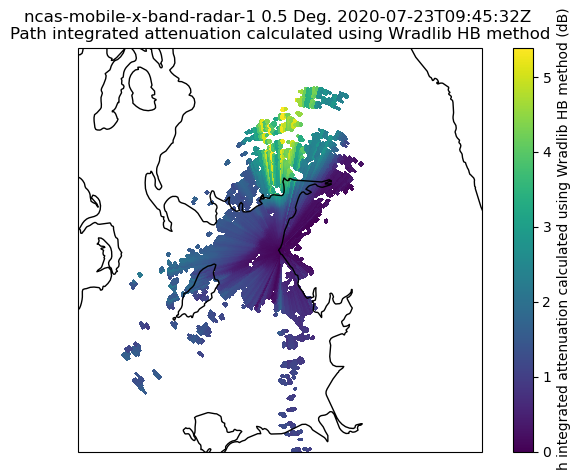

In [6]:
ax1 = plt.subplot(111, projection=proj)
raddisp.plot_ppi_map('attenuation_HB',0, 
                     vmin=0,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax1)

ax1.coastlines(resolution='10m')

plt.tight_layout()

The results from the calculation are the path integrated attenuation (the accumulation of attenuation along the radial). We can use this as a direct correction for the horizontal reflectivity data, using a simple addition. We'll add a new, corrected reflectivity field to the radar object and compare it to the original data with a 2 panel plot.

In [7]:
corrected_reflectivity = radar.fields['dBuZ']['data']+radar.fields['attenuation_HB']['data']
corrected_reflectivity = np.ma.masked_where(gatefilter.gate_excluded,
                                            corrected_reflectivity)

radar.add_field('corrected_reflectivity_HB',
                {'data': corrected_reflectivity,
                 'standard_name': 'Attenuation corrected horizontal reflectivity',
                 'units': 'dBZ'})

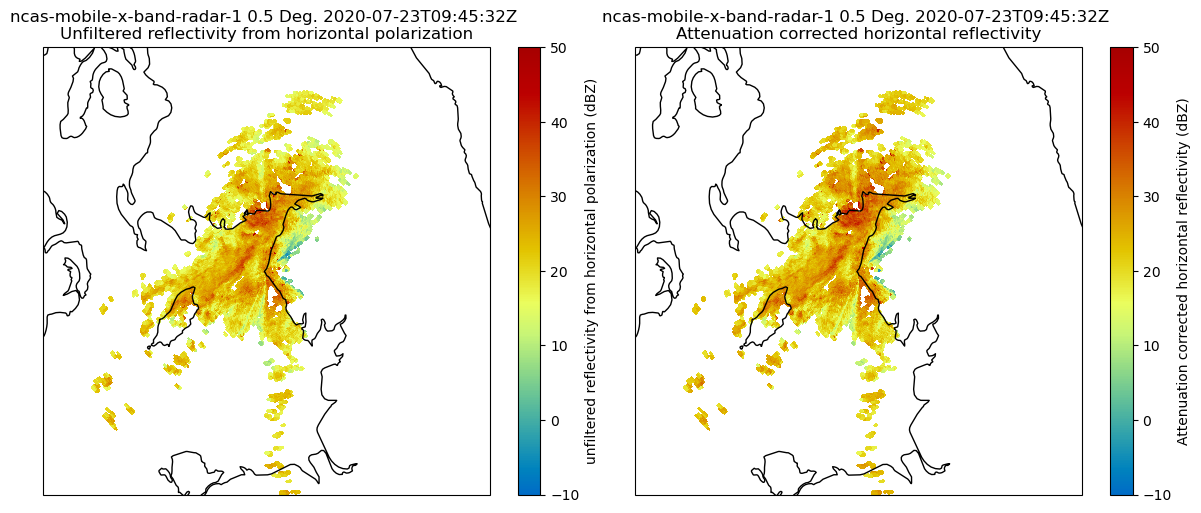

In [8]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=50,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_HB", 0, 
                 cmap=pycm.HomeyerRainbow,
                     vmin=-10, vmax=50,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax2)

ax2.coastlines(resolution='10m')

plt.tight_layout()

##### Activity
Try modifying the gatefilter - make it less aggressive and consider how that impacts the results of the calculation. What if we don't use a gatefilter at all?

The wradlib example notebook (https://docs.wradlib.org/en/latest/notebooks/attenuation/attenuation.html) covers an example of more advanced single polarisation techniques for attenuation correction at C-band but here we will move on to cover attenuation correction using dual-polarisation. 

#### Moving on to dual polarisation

Attenuation correction with dual-polarisation utilises the relationship between the specific differential phase shift and specific attenuation given both are near linearly related to the observed drop-size distribution.

This leads to the following linear relation being used (Bringi and Chandrasekar, 2001):

$A_h(r) = \alpha K_{DP}(r)$

Where the coefficient $\alpha$ is a function of frequency, DSD and temperature.

Given the relation for correcting reflectivity along a radial can be expressed in terms of the integral of specific attenuation as follows:

$Z_c(r) = Z_m(r) + 2\int_0^rA_h(r) \delta r$

We can then substitute specific differential phase shift in proportional to attenuation.

$Z_c(r) = Z_m(r) + 2\alpha\int_0^rK_{DP}(r) \delta r$

And then in terms of the differential phase shift this becomes:

$Z_c(r) = Z_m(r) + 2\alpha[\Phi_{DP}(r) - \Phi_{DP}(0)]$

As a result using dual-polarisation to correct for attenuation relies on the quality of the differential phase shift and specific differential phase shift moments.

We'll now look at two of the differential phase shift moments available within the example file. These are `PhiDP` and `uPhiDPu`, namely the differential phase shift processed by Rainbow (the radar manufacturers processing software) and the differential phase shift directly from the signal processor with Doppler filtering. First we'll plot both as a PPI.

In [9]:
# PhiDP required unfolding first 
# (uPhiDPu has already been unfolded earlier in the practical for input to the gatefilter)

radar.fields['PhiDP']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['PhiDP']['data']>180,
                                                                  radar.fields['PhiDP']['data']-360,
                                                                  radar.fields['PhiDP']['data']),
                                                    mask=radar.fields['PhiDP']['data'].mask)

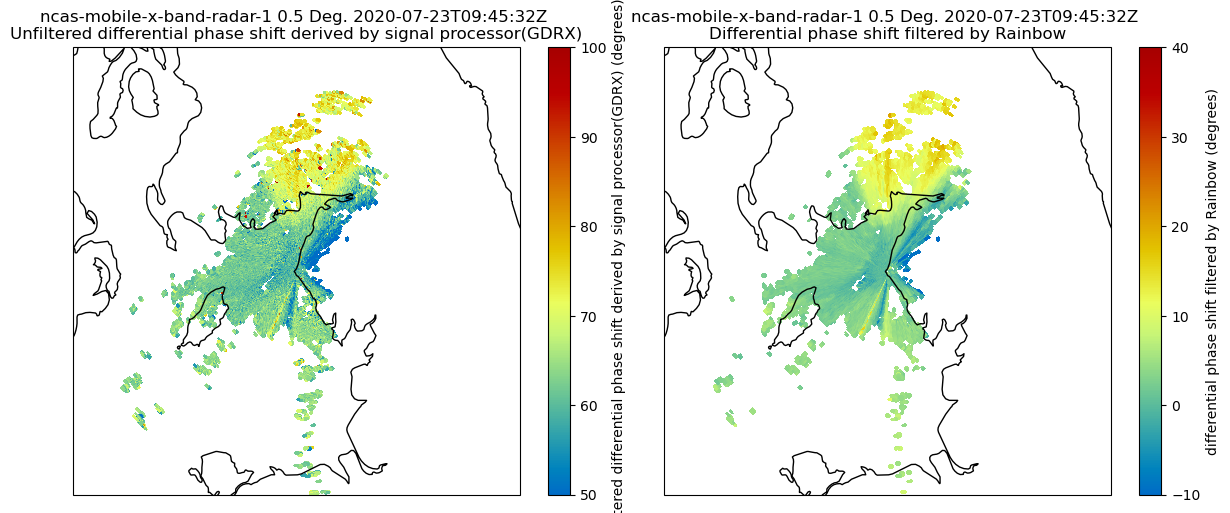

In [10]:
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("uPhiDPu", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=50,vmax=100,
                 ax=ax1)
ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("PhiDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=40,
                 ax=ax2)
ax2.coastlines(resolution='10m')


plt.tight_layout()

- What are the main differences between the two fields?
- Which do you think would be a more appropriate input to an attenuation correction?

To take a closer look, we'll plot a single ray trace for each of the moments, through the area of highest attenuation as calculated using HB earlier.

In [11]:
radar.azimuth['data'][0]

175.00671

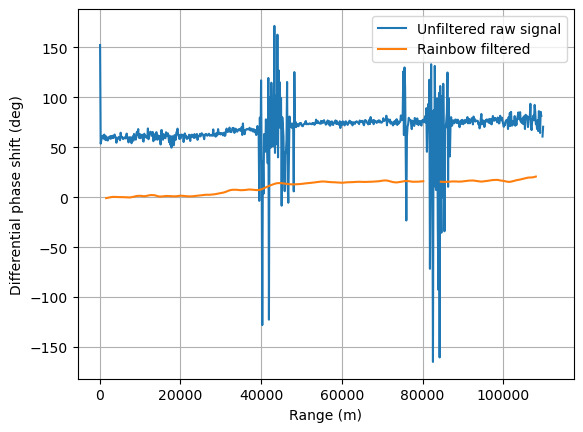

In [12]:
ax1 = plt.subplot(111)

ray_index = 185

plt.plot(radar.range['data'],
         radar.fields['uPhiDPu']['data'][ray_index],label='Unfiltered raw signal')
plt.plot(radar.range['data'],radar.fields['PhiDP']['data'][ray_index], label='Rainbow filtered')
plt.ylabel('Differential phase shift (deg)')
plt.legend()
plt.xlabel('Range (m)')
plt.grid()

As we've already noted, the unfiltered raw signal ('uPhiDPu') still contains the system differential phase. First we will estimate this for this example. You could either try to do this visually or use ```np.mean``` or ```np.median``` to estimate the value for the first few valid gates of 'uPhiDPu' data. Once you have a value you can adjust the ```system_phase``` variable accordingly and create a new plot zoomed towards a phase shift of 0 to 30 degrees.

In [13]:
# Estimate system differential phase here:
#system_phase = 59
system_phase = np.ma.median(radar.fields['uPhiDPu']['data'][ray_index][:10])

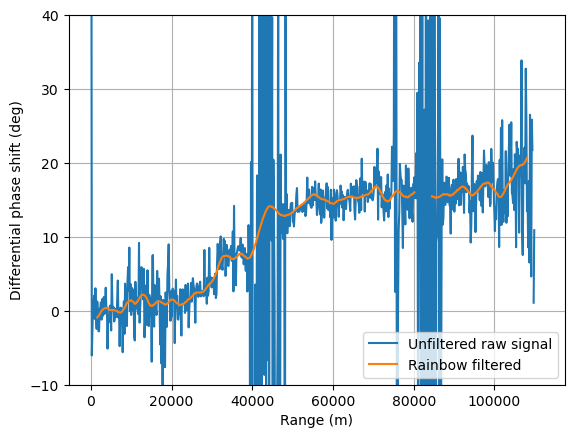

In [14]:
ax1 = plt.subplot(111)
plt.plot(radar.range['data'],
         radar.fields['uPhiDPu']['data'][ray_index]-system_phase,
         label='Unfiltered raw signal')
plt.plot(radar.range['data'],radar.fields['PhiDP']['data'][ray_index], label='Rainbow filtered')
plt.ylabel('Differential phase shift (deg)')
plt.legend()
plt.xlabel('Range (m)')
plt.ylim(-10,40)
plt.grid()

Comparing the ray traces of the two moments we can see that the Rainbow filtered generally smooths out the noise within the raw data but that it is still not monotonically increasing as would be expected for differential phase shift in rain.

We'll examine a couple of the methodologies coded within Py-ART for generating $K_{DP}$ (and smoothed $\Phi_{DP}$) as an alternative to using the Rainbow filtered option. It may be that in other datasets that only a noisy differential phase shift is available (with no $K_{DP}$ at all) or that you are unhappy with the filtered version within the files and which to explore alternatives. Here we'll look at the Py-ART implementation of methods by [Vulpiani et al.](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.kdp_vulpiani.html) and by [Maesaka et al.](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.kdp_maesaka.html), both using the default parameters as much as possible - the Py-ART documentation and the research papers the methods are published in are both good resources for tweaking the processing further in the future.

In [15]:
kdp_maesaka = pyart.retrieve.kdp_maesaka(radar,gatefilter=gatefilter,psidp_field='uPhiDPu')

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [16]:
kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar,gatefilter=gatefilter,psidp_field='uPhiDPu',band='X')

Each method outputs $K_{DP}$ and a smoothed $\Phi_{DP}$ (2 versions in the case of Maesaka). Now we'll plot the differential phase shift output for both methods alongside our original moments.

(-10.0, 30.0)

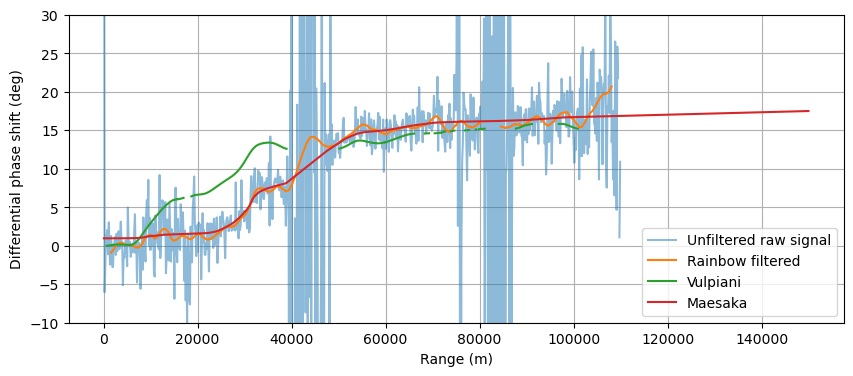

In [17]:
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(111)

ray_index = 185

plt.plot(radar.range['data'],
         radar.fields['uPhiDPu']['data'][ray_index]-system_phase,
         alpha=0.5,label='Unfiltered raw signal')
plt.plot(radar.range['data'],radar.fields['PhiDP']['data'][ray_index], label='Rainbow filtered')


plt.plot(radar.range['data'],
         kdp_vulpiani[1]['data'][ray_index], label='Vulpiani')

plt.plot(radar.range['data'],
         kdp_maesaka[1]['data'][ray_index]-system_phase, label='Maesaka')


plt.ylabel('Differential phase shift (deg)')
plt.legend(loc=4)
plt.xlabel('Range (m)')
plt.grid()
plt.ylim(-10,30)


Clearly there are some differences between the two new methods and the original data.

To correct for attenuation we'll use the Maesaka differential phase shift. Feel free to compare using the other methods too. First it will need adding to the radar object and then we can use Py-ARTs inbuilt linear correction function [```pyart.correct.calculate_attenuation_philinear```](https://arm-doe.github.io/pyart/API/generated/pyart.correct.calculate_attenuation_philinear.html). After this you may also want to explore the use of the Z-PHI method for attenuation correction. The same considerations apply in terms of phase smoothing for that method, but it also considers the distribution of reflectivity measurements to derive specific attenuation.

In [18]:
radar.add_field('PhiDP_Maesaka', kdp_maesaka[1])

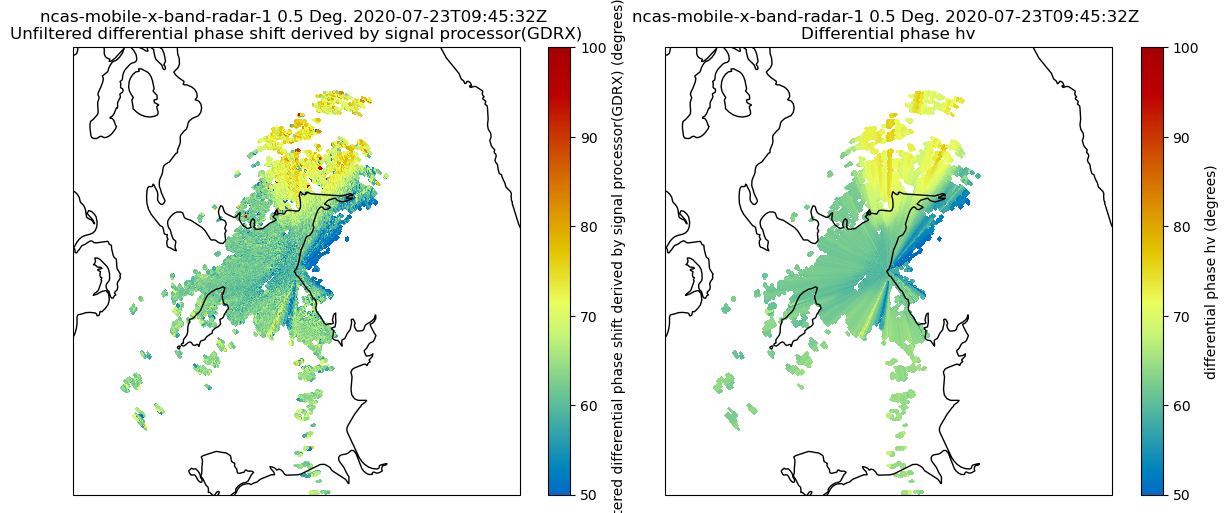

In [19]:
fig = plt.figure(figsize=(12,5))

ax1 = plt.subplot(121, projection=proj)
raddisp.plot_ppi_map("uPhiDPu", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=50,vmax=100,
                 ax=ax1)
ax1.coastlines(resolution='10m')

ax2 = plt.subplot(122, projection=proj)
raddisp.plot_ppi_map("PhiDP_Maesaka", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=50,vmax=100,
                 ax=ax2)
ax2.coastlines(resolution='10m')


plt.tight_layout()

In [20]:
linear_correction_results  = pyart.correct.calculate_attenuation_philinear(radar,
                                                                           gatefilter=gatefilter,
                                                                           phidp_field='PhiDP_Maesaka',
                                                                           refl_field='dBuZ',
                                                                           zdr_field='ZDR',
                                                                           fzl=2500,
                                                                           temp_ref='fixed_fzl')

In [21]:
radar.add_field('linear_PIA',linear_correction_results[1])

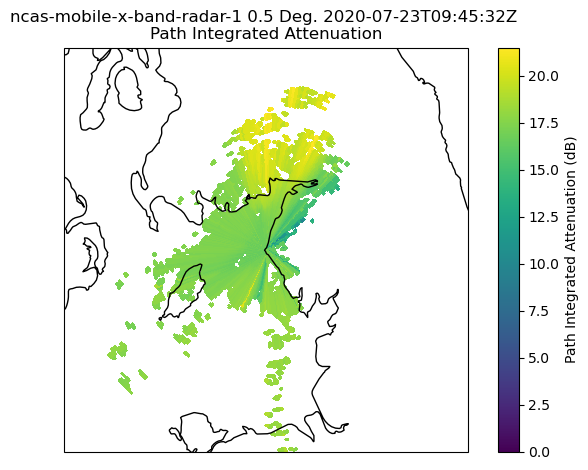

In [22]:
ax1 = plt.subplot(111, projection=proj)
raddisp.plot_ppi_map('linear_PIA',0, 
                     vmin=0,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax1)

ax1.coastlines(resolution='10m')

plt.tight_layout()

These results are much higher than expected. Can anyone think where we've gone wrong with the code?

#### Correction

The differential phase shift computed by the Maesaka method still contained the system phase offset (as did our raw differential phase shift). Therefore the calculation was taking phase to start at 0 for each radial and then instantly jump to the system phase, hence adding ~15dB of attenuation to all the radials. We need to remove the system phase before computing the linear relation with attenuation.

In [23]:
radar.fields['PhiDP_Maesaka']['data'] = radar.fields['PhiDP_Maesaka']['data']-system_phase

In [24]:
linear_correction_results2  = pyart.correct.calculate_attenuation_philinear(radar,
                                                                           gatefilter=gatefilter,
                                                                           phidp_field='PhiDP_Maesaka',
                                                                            #pia_coef=0.26,
                                                                           refl_field='dBuZ',
                                                                           zdr_field='ZDR',
                                                                           fzl=2500,
                                                                           temp_ref='fixed_fzl')

In [25]:
radar.add_field('linear_PIA2',linear_correction_results2[1],replace_existing=True)

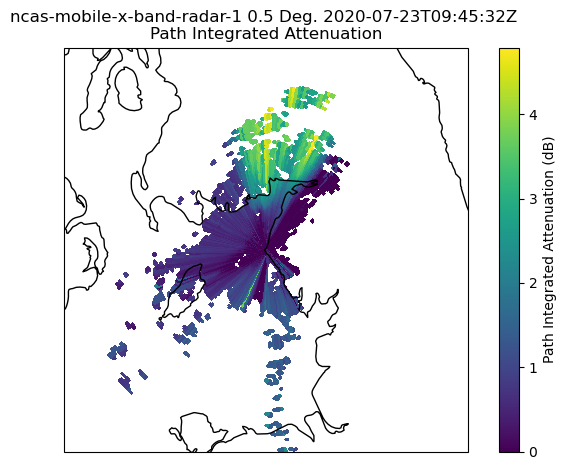

In [26]:
ax1 = plt.subplot(111, projection=proj)
raddisp.plot_ppi_map('linear_PIA2',0, 
                     vmin=0,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax1)

ax1.coastlines(resolution='10m')

plt.tight_layout()

Finally we'll add the corrected reflectivity from the linear results to the radar object and compare those to the uncorrected and HB corrected reflectivity.

In [27]:
radar.add_field("corrected_reflectivity_Phase",
                linear_correction_results2[2])

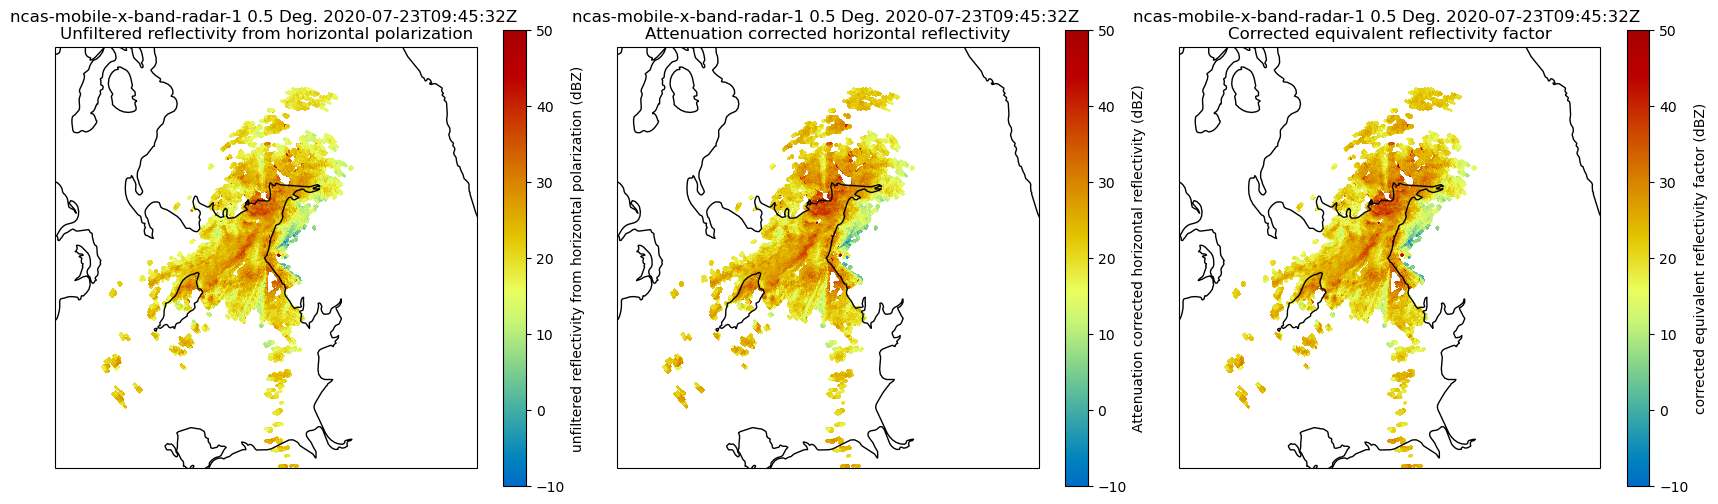

In [28]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(17,5))

ax1 = plt.subplot(131, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                     gatefilter=gatefilter,
                     vmin=-10,vmax=50,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(132, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_HB", 0, 
                 cmap=pycm.HomeyerRainbow,
                     vmin=-10, vmax=50,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax2)

ax2.coastlines(resolution='10m')

ax3 = plt.subplot(133, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_Phase", 0, 
                 cmap=pycm.HomeyerRainbow,
                     vmin=-10, vmax=50,  
                     embellish=False,
                     gatefilter=gatefilter,
                     ax=ax3)

ax3.coastlines(resolution='10m')

plt.tight_layout()

In this example the two approaches (single and dual-pol) produce very similar results. You should investigate attenuation correction with your own case study data and see if the same is true for those. While the correction in this case is quite small, at X-band it is possible for strong convection to product over 50 degrees of differential phase shift (and potentially total attenuation of the signal).

#### Next steps:

In the next exercise we'll look at the generation of QPE before and after some filtering and correction.